In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.data.configparser import EvalConfigParser
import configparser
from typing import Any
from bbtoolkit.structures.synapses import TensorGroup, DirectedTensor, dict2directed_tensor
from bbtoolkit.math import pol2cart
from bbtoolkit.preprocessing.neural_generators import GCMap
from bbtoolkit.preprocessing.environment import Environment
from bbtoolkit.preprocessing.neural_generators import MTLGenerator, TCGenerator


In [2]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

['../cfg/connectivity/main.ini']

In [3]:
def connectivity_config2dict(
    config: EvalConfigParser,
    populations: tuple[str, ...] = None,
    ignore: tuple[str, ...] = None
) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.
        ignore (tuple[str, ..], optional): A tuple of sections to ignore. 'ExternalSources' and 'Hyperparameters' sections are always ignored. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    if ignore is None:
        ignore = {'ExternalSources', 'Hyperparameters'}
    else:
        ignore = set(list(ignore) + ['ExternalSources', 'Hyperparameters'])

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ignore
    }
    return out

In [4]:
configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = TensorGroup(*connections)

In [5]:
simconfig_path = '../cfg/simulation/one_one.ini'
simconfig = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
simconfig.read(simconfig_path)

dt = simconfig.eval('Simulation', 'dt')
step = simconfig.eval('Simulation', 'step')
lesion_noise_level =  simconfig.eval('Simulation', 'lesion_noise_level')
fr_noise_level = simconfig.eval('Simulation', 'fr_noise_level')

In [6]:
mtl_weights = TensorGroup.load('../data/weights/mtl_weights.pkl')
tc_weights = TensorGroup.load('../data/weights/tc_weights.pkl')
hd_weights = TensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = TensorGroup.load('../data/weights/pc_weights.pkl')
gc_map = GCMap.load('../data/weights/gc_map.pkl')

In [7]:
weights = mtl_weights + tc_weights + hd_weights + pc_weights

In [8]:
n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.pc)
n_gc_neurons = len(weights.gc.to.pc.T)
n_tc_layers = len(weights.tr.to.pw.T)

In [9]:
n_h_neurons, n_bvc_neurons, n_pr_neurons, n_hd_neurons, n_gc_neurons, n_opw_neurons, n_ovc_neurons

(6400, 816, 2, 100, 700, 816, 816)

In [10]:
tr_projection = TensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

# initialize activity to zeros

h_act = np.zeros((n_h_neurons, 1))
bvc_act = np.zeros((n_bvc_neurons, 1))
pr_act = np.zeros((n_pr_neurons, 1))
pw_act = bvc_act.copy()
hd_act = np.zeros((n_hd_neurons, 1))
ovc_act = bvc_act.copy()
opw_act = bvc_act.copy()
tr_act = np.zeros((n_tc_layers, n_bvc_neurons, 1))
gc = np.reshape(gc_map.fr, (*gc_map.fr.shape[:2], -1))

In [11]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')

training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

environment = Environment.load('../data/envs/main_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    h_sig,
    sigma_angular,
    n_steps
)

mtl_gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, environment
)

In [12]:
h_coords, *_ = mtl_gen.get_coords()
pdist, pang = tc_gen.polar_distance, tc_gen.polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [13]:
trajectory_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
trajectory_cfg.read('../cfg/trajectory/papez_circuit_lesion.ini')

agent_cfg = trajectory_cfg['AgentPosition']
agent_x = agent_cfg.eval('x')
agent_y = agent_cfg.eval('y')
agent_hd = agent_cfg.eval('theta', locals={'pi': np.pi})
agent_v = agent_cfg.eval('v')

mode_cfg = trajectory_cfg['Mode']
perception = mode_cfg.eval('perception')
imagery = mode_cfg.eval('imagery')
movement = mode_cfg.eval('movement')
imaginary_movement = mode_cfg.eval('imaginary_movement')
stand_time = mode_cfg.eval('stand_t')

targets_cfg = trajectory_cfg['Targets']
locate_next_target = targets_cfg.eval('locate_next_target')
move_to_next_target = targets_cfg.eval('move_to_next_target')
rotation_resolved = targets_cfg.eval('rotation_resolved')
targets = np.array(targets_cfg.eval('targets'))

itargets_cfg = trajectory_cfg['ImaginaryTargets']
ilocate_next_target = itargets_cfg.eval('locate_next_target')
imove_to_next_target = itargets_cfg.eval('move_to_next_target')
irotation_resolved = itargets_cfg.eval('rotation_resolved')
itargets = np.array(itargets_cfg.eval('targets'))
idwell_time = itargets_cfg.eval('dwell')

objects_cfg = trajectory_cfg['Objects']
object_coords = np.array(objects_cfg.eval('coords'))
encoding_threshold = objects_cfg.eval('encoding_threshold')


connectivity_modified = connectivity.operation_with(
    TensorGroup(
        *dict2directed_tensor(
            connectivity_config2dict(
                trajectory_cfg, ignore=('AgentPosition', 'Mode', 'Targets', 'ImaginaryTargets', 'Objects')
            )
        )
    ),
    lambda dict1, dict2:
        {
            key: dict1.get(key, 1) * dict2.get(key, 1)
            for key in set(dict1) | set(dict2)
        }
)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from bbtoolkit.math.geometry import create_cartesian_space, regroup_min_max
from shapely import Polygon

from bbtoolkit.structures.geometry import TexturedPolygon
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.data.configparser import EvalConfigParser
import configparser
from typing import Any, Callable, Literal
from bbtoolkit.structures.synapses import TensorGroup, DirectedTensor, dict2directed_tensor
from bbtoolkit.math import pol2cart
from bbtoolkit.preprocessing.neural_generators import GCMap
from bbtoolkit.preprocessing.environment import Environment, EnvironmentCompiler, Object, SpatialParameters
from bbtoolkit.preprocessing.neural_generators import MTLGenerator, TCGenerator


from collections import OrderedDict
from functools import partial
from bbtoolkit.data import Cached
from bbtoolkit.preprocessing.environment import DynamicEnvironmentCompiler, LazyVisiblePlane
from bbtoolkit.preprocessing.environment import EnvironmentBuilder



def env2builder(environment: Environment) -> EnvironmentBuilder:
    xy_min = np.min(environment.room.boundary.xy)
    xy_max = np.max(environment.room.boundary.xy)
    xy_train_min = tuple(np.min(environment.visible_area.boundary.xy, 1))
    xy_train_max = tuple(np.max(environment.visible_area.boundary.xy, 1))
    res = environment.params.res
    builder = EnvironmentBuilder(xy_min, xy_max, xy_train_min, xy_train_max, res)

    for wall in environment.walls:
        builder.add_wall(wall.polygon)
    for obj in environment.objects:
        builder.add_object(obj.polygon)

    return builder

environment = Environment.load('../data/envs/main_environment.pkl')
compiler = DynamicEnvironmentCompiler(
    env2builder(environment),
    partial(
        LazyVisiblePlane,
        cache_manager=Cached(cache_storage=OrderedDict(), max_size=10000),
    )
)

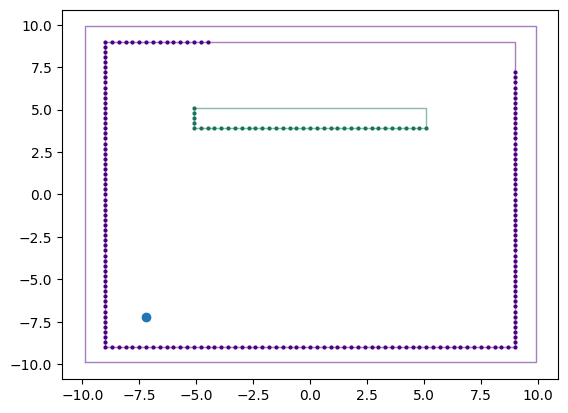

In [15]:
from bbtoolkit.preprocessing.environment.viz import plot_polygon


env = compiler.environment

fig, ax = plt.subplots()
position = 1000
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    env.params.coords[position, 0],
    env.params.coords[position, 1],
    'o'
)

In [174]:
from shapely import Point
from bbtoolkit.structures.geometry import Texture, TexturedPolygon


compiler.add_object(
    TexturedPolygon(
        [
            Point(-7.5, -7.5),
            Point(-7, -7.5),
            Point(-7, -7),
            Point(-7.5, -7)
        ],
        texture=Texture(
            21,
            '#fff44b',
            'obj_main'
        )
    ),
    TexturedPolygon(
        [
            Point(-4.5, -4.5),
            Point(-4, -4.5),
            Point(-4, -4),
            Point(-4.5, -4)
        ],
        texture=Texture(
            21,
            '#fff44b',
            'obj_main'
        )
    ),
    TexturedPolygon(
        [
            Point(7.5, -7.5),
            Point(7, -7.5),
            Point(7, -7),
            Point(7.5, -7)
        ],
        texture=Texture(
            21,
            '#fff44b',
            'obj_main'
        )
    )
)

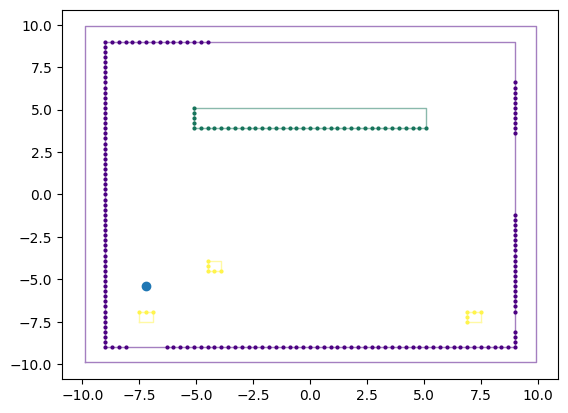

In [175]:
from bbtoolkit.preprocessing.environment.viz import plot_polygon


env = compiler.environment

fig, ax = plt.subplots()
position = 1000
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    env.params.coords[position, 0],
    env.params.coords[position, 1],
    'o'
)

In [176]:
def get_fov(phi, theta):
    # Calculate the lower and upper bounds of the field of view
    lower_bound = (phi - theta/2) % (2*np.pi)
    upper_bound = (phi + theta/2) % (2*np.pi)

    return lower_bound, upper_bound


def visible_points(coords_list, location, angle1, angle2):
    visible_points_list = []

    for coords in coords_list:
        # Calculate the relative coordinates
        relative_coords = coords - location

        # Calculate the angles
        angles = np.arctan2(relative_coords[:,1], relative_coords[:,0]) % (2 * np.pi)

        # Filter the points
        visible = ((angles >= angle1) & (angles <= angle2)) | ((angles + 2 * np.pi >= angle1) & (angles + 2 * np.pi <= angle2))

        visible_points_list.append(coords[visible])

    return visible_points_list

In [177]:
class FOVManager:
    def __init__(
        self,
        environment: Environment,
        fov: float
    ):
        self.environment = environment
        self.fov = fov

    def __call__(
        self,
        position: tuple[float, float],
        direction: float,
    ):
        phi1, phi2 = get_fov(direction, self.fov)
        objects_fov = visible_points(
            [
                obj.visible_parts(*position)
                for obj in self.environment.objects
            ],
            position, phi1, phi2
        )
        walls_fov = visible_points(
            [
                wall.visible_parts(*position)
                for wall in self.environment.walls
            ],
            position, phi1, phi2
        )
        return walls_fov, objects_fov

In [178]:
def plot_arrow(angle: float, x: float, y: float, ax: plt.Axes = None, **kwargs) -> plt.Figure:
    """
    Plot an arrow at a specified angle with given x and y coordinates.

    Args:
        angle (float): Angle in radians (from 0 to 2*pi).
        x (float): X-coordinate of the arrow.
        y (float): Y-coordinate of the arrow.
        ax (plt.Axes): Optional axis for the plot. If not provided, a new plot is created.
        **kwargs: Keyword arguments passed to the matplotlib.pyplot.arrow function.

    Returns:
        plt.Figure: The figure on which the arrow is plotted.
    """

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    kwargs.setdefault('head_width', 1)
    kwargs.setdefault('head_length', 1)
    kwargs.setdefault('fc', 'red')
    kwargs.setdefault('ec', 'red')

    # Calculate the arrow components
    arrow_length = 0.2
    dx = arrow_length * np.cos(angle)
    dy = arrow_length * np.sin(angle)

    # Plot the arrow
    ax.arrow(x, y, dx, dy, **kwargs)

    return fig

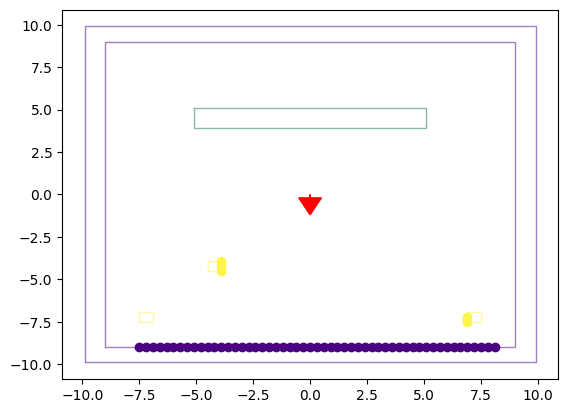

In [179]:
fov_angle = np.pi/2
fov_manager = FOVManager(compiler.environment, fov_angle)
position = -0, 0
direction = -np.pi/2
walls_fov, objects_fov = fov_manager(position, direction)

fig, ax = plt.subplots()
fig = plot_arrow(direction, *position, ax=ax)

for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

for wall, poly in zip(walls_fov, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color)

for obj, poly in zip(objects_fov, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color)


In [180]:
compiler.add_object(
    TexturedPolygon(
        [
            Point(5, -5),
            Point(4.5, -5),
            Point(4.5, -4.5),
            Point(5, -4.5)
        ],
        texture=Texture(
            21,
            '#fff44b',
            'obj_main'
        )
    )
)

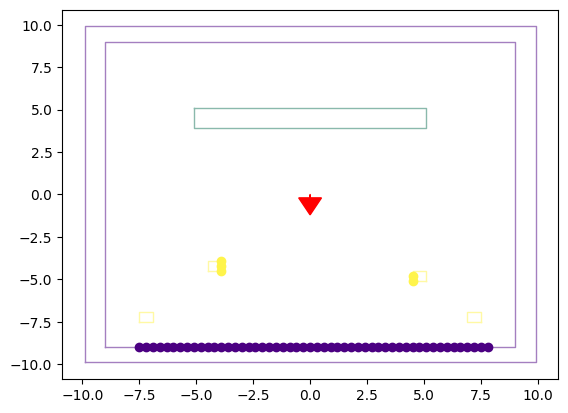

In [181]:

fov_angle = np.pi/2
fov_manager = FOVManager(compiler.environment, fov_angle)
position = -0, 0
direction = -np.pi/2
walls_fov, objects_fov = fov_manager(position, direction)

fig, ax = plt.subplots()
fig = plot_arrow(direction, *position, ax=ax)

for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

for wall, poly in zip(walls_fov, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color)

for obj, poly in zip(objects_fov, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color)


In [182]:
compiler.remove_object(-1)

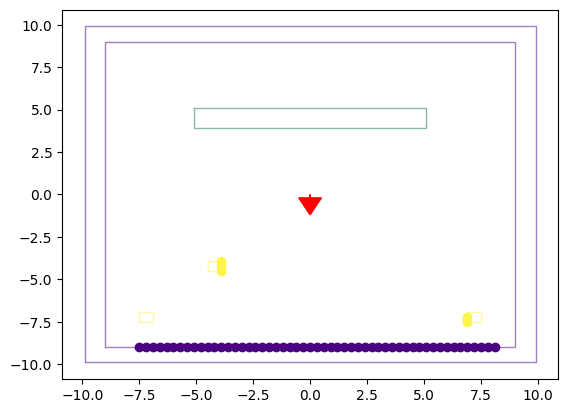

In [183]:

fov_angle = np.pi/2
fov_manager = FOVManager(compiler.environment, fov_angle)
position = -0, 0
direction = -np.pi/2
walls_fov, objects_fov = fov_manager(position, direction)

fig, ax = plt.subplots()
fig = plot_arrow(direction, *position, ax=ax)

for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

for wall, poly in zip(walls_fov, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color)

for obj, poly in zip(objects_fov, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color)


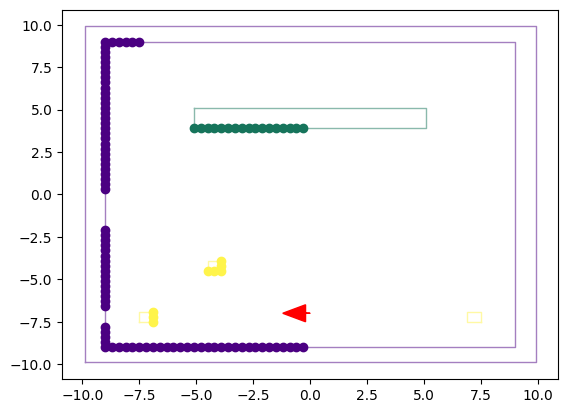

In [185]:
fov_angle = np.pi
fov_manager = FOVManager(compiler.environment, fov_angle)
position = 0, -7
direction = np.pi
walls_fov, objects_fov = fov_manager(position, direction)

fig, ax = plt.subplots()
fig = plot_arrow(direction, *position, ax=ax)

for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

for wall, poly in zip(walls_fov, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color)

for obj, poly in zip(objects_fov, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color)
